In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

# Custom Logistic Regression Implementation

In [2]:
from sklearn.utils.validation import check_X_y, check_array

class CustomLogisticRegression():
    def __init__(self, normalize=True, learning_rate=0.01, num_iters=1000):
        self.normalize = normalize
        self.is_fitted = False
        self.learning_rate = learning_rate
        self.num_iters = num_iters

    def __str__(self):
        return f"Logistic Regression, alpha: {self.learning_rate}, iters: {self.num_iters}"
        
    def __normalize(self, X):
        mean = np.zeros([X.shape[1]])
        std  = np.ones([X.shape[1]])
        
        for i in range(X.shape[1]):
            if (np.std(X[:, i]) != 0):
                mean[i] = np.mean(X[:, i])
                std[i] = np.std(X[:, i])
        X_new = (X - mean) / std
        return X_new, mean, std

    def __prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new

    def __derivative(self, X, y, theta):
        m = X.shape[0]
        h0 = self.__hypothesis(X, theta)
        d_theta = (1 / m) * X.T.dot((h0 - y))
        return d_theta

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __hypothesis(self, X, theta):
        h_thetha = np.dot(X, theta)
        return self.__sigmoid(h_thetha)
    
    def __gradient_descent(self, X, y, theta, epsilon):
        m = X.shape[0]
        J_history = []
        J = self.cost_function(X, y, theta)

        J_history.append(J)
        for i in range(self.num_iters):
            delta = self.__derivative(X, y, theta)
            theta = theta - self.learning_rate * delta
            J = self.cost_function(X, y, theta)

            J_history.append(J)
            
            if i > 1 and abs(J_history[-2] - J_history[-1]) < epsilon:
                break
                
        return theta, J_history

    def fit(self, X, y, learning_rate=0.001, num_iters=1000, epsilon=1e-8):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.y_ = y
        self.num_iters = num_iters
        self.learning_rate = learning_rate

        if self.normalize == True:
            X_norm, self.__mean, self.__std = self.__normalize(X)
            self.X_ = self.__prepare_X(X_norm)
        
        else:
            self.X_ = self.__prepare_X(X)

        theta = np.zeros(self.X_.shape[1])
        self.coef_, self.Js = self.__gradient_descent(self.X_, self.y_, theta, epsilon)
        self.is_fitted = True

    def predict(self, X):
        pred = self.predict_proba(X)
        return (pred >= 0.5).astype(int)

    def predict_proba(self, X):
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            X_proc = self.__prepare_X(X_norm)
        else:
            X_proc = self.__prepare_X(X)

        pred = self.__hypothesis(X_proc, self.coef_)        
        return pred

    def cost_function(self, X, y, theta):
        m = X.shape[0]
        if m == 0:
            return None

        h0 = self.__hypothesis(X, theta)
        J = (1 / m) * ( (-y.T).dot(np.log(h0)) - (1 - y).T.dot(np.log(1 - h0)) )
        return J
    
    def get_params(self, deep=True):
        return {
                "learning_rate": self.learning_rate,
                "num_iters": self.num_iters
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Loading and Analysing Dataset

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


####  Data Dictionary
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or - ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]     
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

#### Exploratory Data Analysis

In [4]:
df.shape

(918, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
# Split data into numerical and categorical features 
Categorical = df.select_dtypes(include=['object'])
Numerical = df.select_dtypes(include=['int64', 'float64'])
print('Categorical features:\n', Categorical)
print('Numerical features:\n', Numerical)

Categorical features:
     Sex ChestPainType RestingECG ExerciseAngina ST_Slope
0     M           ATA     Normal              N       Up
1     F           NAP     Normal              N     Flat
2     M           ATA         ST              N       Up
3     F           ASY     Normal              Y     Flat
4     M           NAP     Normal              N       Up
..   ..           ...        ...            ...      ...
913   M            TA     Normal              N     Flat
914   M           ASY     Normal              N     Flat
915   M           ASY     Normal              Y     Flat
916   F           ATA        LVH              N     Flat
917   M           NAP     Normal              N       Up

[918 rows x 5 columns]
Numerical features:
      Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
0     40        140          289          0    172      0.0             0
1     49        160          180          0    156      1.0             1
2     37        130       

In [9]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## Visualization

#### Normal and Heart Disease with target column

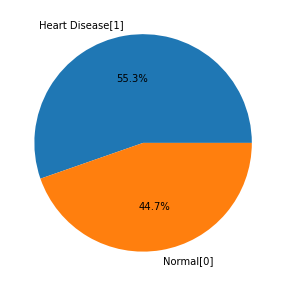

In [10]:
plt.figure(figsize=(10,5))
plt.pie(df['HeartDisease'].value_counts(), labels=['Heart Disease[1]', 'Normal[0]'], autopct='%1.1f%%')
plt.show()

#### Ploting corelation matrix

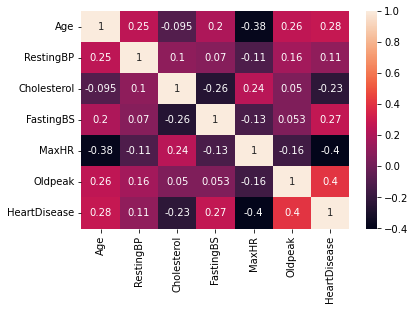

In [11]:
sns.heatmap(df.corr(), annot=True)
plt.show()

#### Pairplot using target HeartDisease Column

<Figure size 1080x720 with 0 Axes>

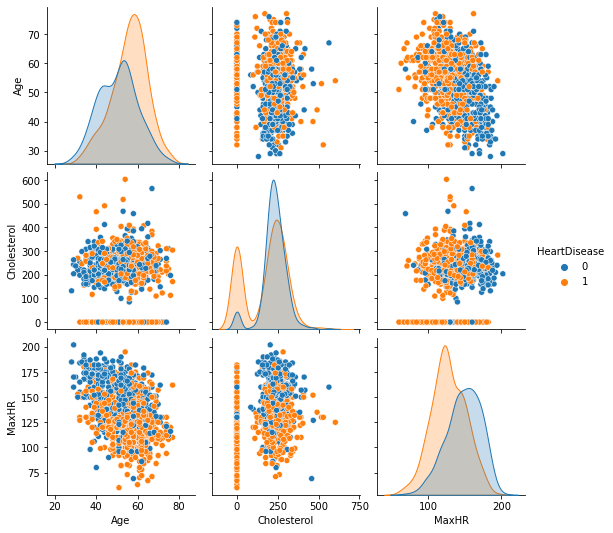

In [12]:
fig = plt.figure(figsize=(15, 10))
a = df.copy()
res = a.drop(columns=["RestingBP", "FastingBS", "Oldpeak"])
g = sns.pairplot(res, hue='HeartDisease')
g.fig.savefig("correlation.pdf")

#### Distribution plot of Age for HeartDisease

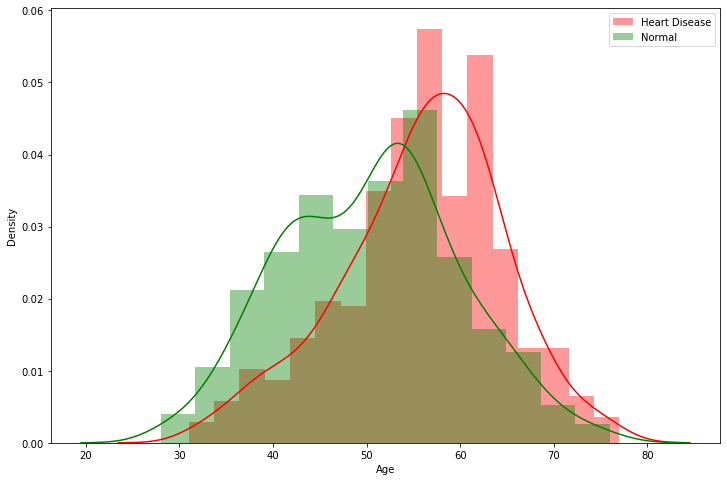

In [13]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(df['Age'][df['HeartDisease'] == 1], kde=True, color='red', label='Heart Disease')
sns.distplot(df['Age'][df['HeartDisease'] == 0], kde=True, color='green', label='Normal')
plt.legend()
fig.savefig("age_distribution.pdf")

#### Data Preprocessing

In [14]:
# select numerical features and encoding it
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# apply label encoding
numerical_features = numerical_features.apply(LabelEncoder().fit_transform)
numerical_features.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,12,41,147,0,98,10,0
1,21,55,40,0,82,20,1
2,9,31,141,0,25,10,0
3,20,39,72,0,34,25,1
4,26,49,53,0,48,10,0


In [15]:
# One-Hot encoding the categorical features using get_dummies()
# select categorical features
categorical_features = df.select_dtypes(include=['object'])
# apply get_dummies encoding
categorical_features = pd.get_dummies(categorical_features)
categorical_features.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [16]:
# combine numerical and categorical features
combined = pd.concat([numerical_features, categorical_features], axis=1)
combined.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,12,41,147,0,98,10,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,21,55,40,0,82,20,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,9,31,141,0,25,10,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,20,39,72,0,34,25,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,26,49,53,0,48,10,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [17]:
# separet features and target
X = combined.drop(['HeartDisease'], axis=1)
y = combined['HeartDisease']

In [18]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,12,41,147,0,98,10,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,21,55,40,0,82,20,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,9,31,141,0,25,10,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,20,39,72,0,34,25,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,26,49,53,0,48,10,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [19]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [20]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [21]:
data = df

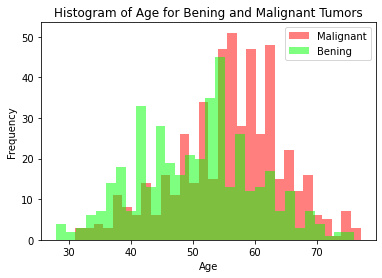

Most frequent malignant radius mean is:  55.53333333333333


In [22]:
m = plt.hist(data[data["HeartDisease"] == 1].Age, bins=30,fc = (1,0,0,0.5),label = "Malignant")
b = plt.hist(data[data["HeartDisease"] == 0].Age, bins=30,fc = (0,1,0,0.5),label = "Bening")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age for Bening and Malignant Tumors")
plt.show()
frequent_malignant_radius_mean = m[0].max()
index_frequent_malignant_radius_mean = list(m[0]).index(frequent_malignant_radius_mean)
most_frequent_malignant_radius_mean = m[1][index_frequent_malignant_radius_mean]
print("Most frequent malignant radius mean is: ",most_frequent_malignant_radius_mean)

# Train test split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models Fitting and Evaluation

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

models = [
    KNeighborsClassifier(n_neighbors=10),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(tol=1.0e-18),
    MLPClassifier(hidden_layer_sizes=(24, 12, 24), random_state=1, max_iter=1000),
    CustomLogisticRegression(normalize=True)
]
models_predictions = []

In [25]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models_predictions.append(y_pred)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def models_evaluation(models, models_predictions, y_test):
    for model, model_predictions in zip(models, models_predictions):
        rmse = mean_squared_error(y_test, model_predictions, squared=True)
        mse = mean_squared_error(y_test, model_predictions, squared=False)
        mae = mean_absolute_error(y_test, model_predictions)
        r2 = r2_score(y_test, model_predictions)
        accuracy = sum(np.array(y_test) == model_predictions)/len(y_test) * 100
        
        print(f"Model: {model}")
        print(f"accuracy: {accuracy}, rmse: {rmse}; mse: {mse}; mae: {mae}; r2: {r2}\n")

models_evaluation(models, models_predictions, y_test)

Model: KNeighborsClassifier(n_neighbors=10)
accuracy: 72.28260869565217, rmse: 0.27717391304347827; mse: 0.5264730886222754; mae: 0.27717391304347827; r2: -0.13897317635635376

Model: LinearDiscriminantAnalysis()
accuracy: 84.78260869565217, rmse: 0.15217391304347827; mse: 0.39009474880274697; mae: 0.15217391304347827; r2: 0.37468139337298223

Model: QuadraticDiscriminantAnalysis(tol=1e-18)
accuracy: 74.45652173913044, rmse: 0.2554347826086957; mse: 0.5054055625027248; mae: 0.2554347826086957; r2: -0.04964194683820833

Model: MLPClassifier(hidden_layer_sizes=(24, 12, 24), max_iter=1000, random_state=1)
accuracy: 83.69565217391305, rmse: 0.16304347826086957; mse: 0.4037864265436241; mae: 0.16304347826086957; r2: 0.3300157786139095

Model: Logistic Regression, alpha: 0.001, iters: 1000
accuracy: 82.6086956521739, rmse: 0.17391304347826086; mse: 0.41702882811414954; mae: 0.17391304347826086; r2: 0.2853501638548368



# Dataset evaluation

## Models Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

X_np = np.array(X_train)
y_np = np.array(y_train)

### LeaveOneOut

In [28]:
def leave_one_out_cv(models=[]):
    cv = LeaveOneOut()
    for model in models:
        scores = cross_val_score(model, X_np, y_np, scoring='accuracy', cv=cv, n_jobs=-1)
        print('Model: %s Accuracy: %.3f (%.3f)' % (model, np.mean(scores), np.std(scores)))

leave_one_out_cv(models)

Model: KNeighborsClassifier(n_neighbors=10) Accuracy: 0.766 (0.424)
Model: LinearDiscriminantAnalysis() Accuracy: 0.862 (0.344)
Model: QuadraticDiscriminantAnalysis(tol=1e-18) Accuracy: 0.583 (0.493)
Model: MLPClassifier(hidden_layer_sizes=(24, 12, 24), max_iter=1000, random_state=1) Accuracy: 0.846 (0.361)
Model: Logistic Regression, alpha: 0.001, iters: 1000 Accuracy: 0.857 (0.350)


In [29]:
def k_fold_out_cv(models=[], folds=10):
    cv = KFold(n_splits=10)
    for model in models:
        scores = cross_val_score(model, X_np, y_np, scoring='accuracy', cv=cv, n_jobs=-1)
        print('Model: %s Accuracy: %.3f (%.3f)' % (model, np.mean(scores), np.std(scores)))

k_fold_out_cv(models)

Model: KNeighborsClassifier(n_neighbors=10) Accuracy: 0.764 (0.043)
Model: LinearDiscriminantAnalysis() Accuracy: 0.858 (0.027)
Model: QuadraticDiscriminantAnalysis(tol=1e-18) Accuracy: 0.688 (0.076)
Model: MLPClassifier(hidden_layer_sizes=(24, 12, 24), max_iter=1000, random_state=1) Accuracy: 0.838 (0.044)
Model: Logistic Regression, alpha: 0.001, iters: 1000 Accuracy: 0.855 (0.035)
